In [ ]:
!pip install underthesea
!pip uninstall torch torchtext -y
!pip install torch==2.0.1 torchtext==0.15.2 torchvision==0.15.2
!pip install gensim
!pip install numpy==1.25.0
!pip install --upgrade gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.6 MB/s eta 0:00:00
Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.2 MB/s eta 0:00:00
   ━━━

## Preparing data and model setup for Vietnamese machine translation using PyTorch and pretrained word embeddings from Gensim.

In [ ]:
# Data processing libraries
import pandas as pd
import numpy as np
import re, string

# Vietnamese tokenizer
from underthesea import word_tokenize

# TorchText tokenizer and vocab
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# Type hints
from typing import Iterable, List

# Pretrained word vectors
from gensim.models import KeyedVectors

# PyTorch & Transformer
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# Timer
from timeit import default_timer as timer

# Math
import math

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Parallel Corpus

In [ ]:
# Dataset directory
data_dir = "/content/drive/MyDrive/Colab Notebooks/deep_learning/EnToVieTranfrom/dataset/"

# Load English and Vietnamese sentences
en_sents = open(data_dir + 'en_sents', "r").read().splitlines()
vi_sents = open(data_dir + 'vi_sents', "r").read().splitlines()

# Create dictionary and convert to DataFrame
data = {
    "en": [line for line in en_sents],
    "vi": [line for line in vi_sents],
}
df = pd.DataFrame(data, columns=["en", "vi"])

# Show dataset size and preview
print(len(en_sents))
df.head()

254090


,en,vi
0,Please put the dustpan in the broom closet,xin vui lòng đặt người quét rác trong tủ chổi
1,Be quiet for a moment.,im lặng một lát
2,Read this,đọc này
3,Tom persuaded the store manager to give him ba...,tom thuyết phục người quản lý cửa hàng trả lại...
4,Friendship consists of mutual understanding,tình bạn bao gồm sự hiểu biết lẫn nhau


## Preprocess Sentences

In [ ]:
def preprocessing(df):
  # Remove punctuation
  df["en"] = df["en"].apply(lambda ele: ele.translate(str.maketrans('', '', string.punctuation)))
  df["vi"] = df["vi"].apply(lambda ele: ele.translate(str.maketrans('', '', string.punctuation)))

  # Convert to lowercase
  df["en"] = df["en"].apply(lambda ele: ele.lower())
  df["vi"] = df["vi"].apply(lambda ele: ele.lower())

  # Strip leading/trailing spaces
  df["en"] = df["en"].apply(lambda ele: ele.strip())
  df["vi"] = df["vi"].apply(lambda ele: ele.strip())

  # Normalize whitespace
  df["en"] = df["en"].apply(lambda ele: re.sub("\s+", " ", ele))
  df["vi"] = df["vi"].apply(lambda ele: re.sub("\s+", " ", ele))

  return df

# Apply preprocessing
df = preprocessing(df)
df.head()

,en,vi
0,please put the dustpan in the broom closet,xin vui lòng đặt người quét rác trong tủ chổi
1,be quiet for a moment,im lặng một lát
2,read this,đọc này
3,tom persuaded the store manager to give him ba...,tom thuyết phục người quản lý cửa hàng trả lại...
4,friendship consists of mutual understanding,tình bạn bao gồm sự hiểu biết lẫn nhau


## Tokenization & Vocabulary

In [ ]:
SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'vi'

token_transform = {}
vocab_transform = {}

# Vietnamese tokenizer using underthesea
def vi_tokenizer(sentence):
    tokens = word_tokenize(sentence)
    return tokens

# Tokenizer for each language
token_transform[SRC_LANGUAGE] = get_tokenizer('basic_english')
token_transform[TGT_LANGUAGE] = get_tokenizer(vi_tokenizer)

# Token generator for vocab building
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    for index, data_sample in data_iter:
        yield token_transform[language](data_sample[language])

# Special token indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

# Build vocab for both source and target languages
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    train_iter = df.iterrows()
    vocab_transform[ln] = build_vocab_from_iterator(
        yield_tokens(train_iter, ln),
        min_freq=1,
        specials=special_symbols,
        special_first=True
    )

# Set default index to UNK
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

## Transformer Model

In [ ]:
# Select device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Positional encoding for tokens
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float = 0.1,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()

        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# Embedding layer with scaling
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Full Seq2Seq Transformer model
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

## Create Attention Masks

In [ ]:
# Generate causal mask for decoder
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

# Create masks for input and target
def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

## Model Setup & Training

In [ ]:
# Set manual seed for reproducibility
torch.manual_seed(0)

# Define model hyperparameters
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 64
NUM_ENCODER_LAYERS = 4
NUM_DECODER_LAYERS = 4
DROP_OUT = 0.1

# Initialize the transformer model
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM, DROP_OUT)

# Xavier initialization for weights
for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

# Move model to device
transformer = transformer.to(DEVICE)

# Loss function with padding index ignored
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Adam optimizer with custom learning rate and betas
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

## Data Transformation & Collation

In [ ]:
# Sequential transformation of text (tokenization, vocab, tensor conversion)
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# Convert token ids to tensor with BOS and EOS tokens
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# Define transformations for source and target languages
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln],
                                               vocab_transform[ln],
                                               tensor_transform)

# Collate function for batching and padding sequences
def collate_fn(batch):
    src_batch, tgt_batch = [], []

    # Apply transformations to each example in the batch
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    # Pad the sequences to have equal lengths
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch


## Dataset Splitting & Preparation

In [ ]:
# Define split ratios for training, validation, and testing
split_ratio_train = 0.8
split_ratio_val = 0.1
split_ratio_test = 0.1

# Calculate split indices
split_train = round(df.shape[0] * split_ratio_train)
split_val = round(df.shape[0] * (split_ratio_train + split_ratio_val))

# Split the DataFrame into train, validation, and test sets
train = df.iloc[:split_train]
val = df.iloc[split_train:split_val]
test = df.iloc[split_val:]

# Create datasets as lists of tuples (input, target)
train_ds = list(zip(train['en'], train['vi']))
val_ds = list(zip(val['en'], val['vi']))
test_ds = list(zip(test['en'], test['vi']))


## Dataset Sample Count Visualization

Số lượng mẫu trong tập huấn luyện (train_ds): 203272
Số lượng mẫu trong tập kiểm tra (val_ds): 25409
Số lượng mẫu trong tập dữ liệu kiểm tra (test_ds): 25409


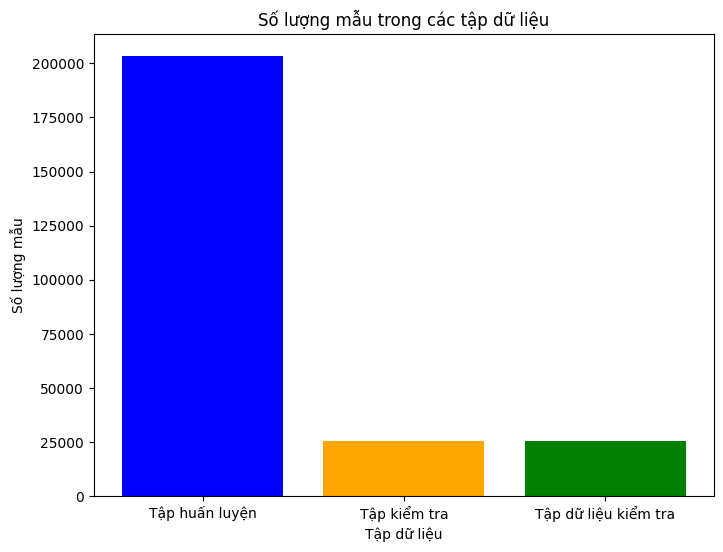

In [ ]:
# Get the number of samples in each dataset
num_train_samples = len(train_ds)
num_val_samples = len(val_ds)
num_test_samples = len(test_ds)

# Print the number of samples in each dataset
print("Số lượng mẫu trong tập huấn luyện (train_ds):", num_train_samples)
print("Số lượng mẫu trong tập kiểm tra (val_ds):", num_val_samples)
print("Số lượng mẫu trong tập dữ liệu kiểm tra (test_ds):", num_test_samples)

# Plot the sample counts
labels = ['Tập huấn luyện', 'Tập kiểm tra', 'Tập dữ liệu kiểm tra']
sample_counts = [num_train_samples, num_val_samples, num_test_samples]

plt.figure(figsize=(8, 6))
plt.bar(labels, sample_counts, color=['blue', 'orange', 'green'])
plt.xlabel('Tập dữ liệu')
plt.ylabel('Số lượng mẫu')
plt.title('Số lượng mẫu trong các tập dữ liệu')
plt.show()


## Training and Evaluation Functions

In [ ]:
# Accumulation steps to accumulate gradients
accumulation_steps = 5

# Training function for one epoch
def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    optimizer.zero_grad()

    # Iterate through the training dataset
    for i, (src, tgt) in enumerate(train_dataloader):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        # Prepare target input (shifted by 1 token)
        tgt_input = tgt[:-1, :]

        # Create masks for the model
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        # Forward pass
        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

        # Prepare target output (shifted by 1 token)
        tgt_out = tgt[1:, :]

        # Compute the loss
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss = loss / accumulation_steps  # Scale loss for accumulation steps
        loss.backward()

        # Update weights every 'accumulation_steps' batches
        if (i+1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        losses += loss.item()

    return losses / len(train_dataloader)

# Evaluation function to compute validation loss
def evaluate(model):
    model.eval()
    losses = 0
    val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    # Iterate through the validation dataset
    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        # Prepare target input and create masks
        tgt_input = tgt[:-1, :]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        # Forward pass
        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

        # Prepare target output
        tgt_out = tgt[1:, :]

        # Compute the loss
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss = loss / accumulation_steps  # Scale loss for accumulation steps
        losses += loss.item()

    return losses / len(val_dataloader)

## Early Stopping

In [ ]:
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):
        # tolerance: number of epochs without improvement before stopping
        # min_delta: minimum change to qualify as an improvement
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0  # Counter for epochs without improvement
        self.early_stop = False  # Flag to indicate when to stop

    def __call__(self, train_loss, validation_loss):
        # If validation loss is greater than train loss by a margin defined by min_delta
        if (validation_loss - train_loss) > self.min_delta:
            self.counter += 1  # Increment counter
            if self.counter >= self.tolerance:
                # Stop training if tolerance is reached
                self.early_stop = True
        else:
            self.counter = 0  # Reset counter if improvement is found

## Training Loop with Early Stopping

In [ ]:
# Early stopping setup
early_stopping = EarlyStopping(tolerance=5, min_delta=0.1)

# Training loop
NUM_EPOCHS = 15
history = {"loss": [], "val_los": []}

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = timer()  # Start timer for epoch
    train_loss = train_epoch(transformer, optimizer)  # Train the model
    end_time = timer()  # End timer

    val_loss = evaluate(transformer)  # Validate the model
    history['loss'].append(train_loss)  # Track training loss
    history['val_los'].append(val_loss)  # Track validation loss

    # Print epoch info
    print(f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Epoch time = {(end_time - start_time):.3f}s")

    # Apply early stopping
    early_stopping(train_loss, val_loss)
    if early_stopping.early_stop:  # Stop if criteria met
        print("Early stopping at epoch:", epoch)
        break  # Break out of loop

Epoch: 1, Train loss: 0.874, Val loss: 0.538, Epoch time = 227.638s
Epoch: 2, Train loss: 0.459, Val loss: 0.344, Epoch time = 227.090s
Epoch: 3, Train loss: 0.321, Val loss: 0.263, Epoch time = 225.729s
Epoch: 4, Train loss: 0.252, Val loss: 0.223, Epoch time = 225.964s
Epoch: 5, Train loss: 0.210, Val loss: 0.198, Epoch time = 225.342s
Epoch: 6, Train loss: 0.181, Val loss: 0.181, Epoch time = 227.047s
Epoch: 7, Train loss: 0.160, Val loss: 0.169, Epoch time = 229.896s
Epoch: 8, Train loss: 0.143, Val loss: 0.163, Epoch time = 229.094s
Epoch: 9, Train loss: 0.130, Val loss: 0.156, Epoch time = 226.037s
Epoch: 10, Train loss: 0.119, Val loss: 0.151, Epoch time = 228.816s
Epoch: 11, Train loss: 0.109, Val loss: 0.147, Epoch time = 232.882s
Epoch: 12, Train loss: 0.101, Val loss: 0.145, Epoch time = 233.790s
Epoch: 13, Train loss: 0.094, Val loss: 0.142, Epoch time = 233.861s
Epoch: 14, Train loss: 0.088, Val loss: 0.140, Epoch time = 233.618s
Epoch: 15, Train loss: 0.082, Val loss: 0.1

## Plotting the Training and Validation Loss

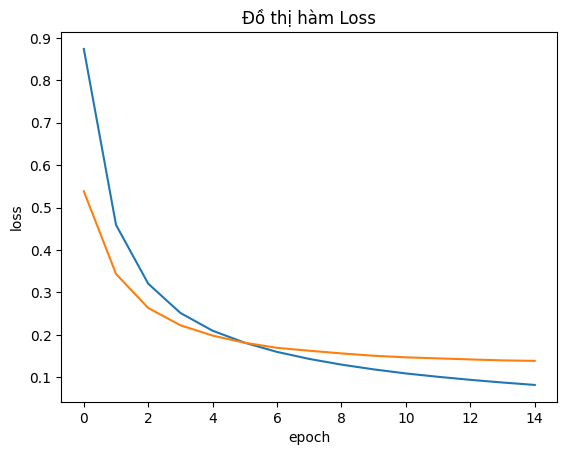

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training and validation loss
plt.plot(history['loss'], label = "loss")
plt.plot(history['val_los'], label = "Val loss")
plt.xlabel('epoch')  # X-axis: Epoch number
plt.ylabel('loss')   # Y-axis: Loss value
plt.title('Đồ thị hàm Loss')  # Title: Loss Graph
plt.legend()  # Show legend for labels

## Greedy Decoding and Translation

In [ ]:
# Greedy Decoding function for translation
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    # Encode the source sentence
    memory = model.encode(src, src_mask)

    # Initialize target sequence with the start symbol
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)

    # Generate tokens for the target sequence
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(DEVICE)

        # Decode the target sequence
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)

        # Get the most probable next word
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        # Append the next word to the target sequence
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)

        # Stop if EOS (End Of Sentence) token is generated
        if next_word == EOS_IDX:
            break

    return ys

# Translate a sentence from source to target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()

    # Transform source sentence into token IDs
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]

    # Create a mask for the source tokens
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)

    # Perform greedy decoding to generate the translated sentence
    tgt_tokens = greedy_decode(model, src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()

    # Convert token IDs back to words and return the translation
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")


## Evaluating Translation Quality with BLEU Score

In [ ]:
import nltk
from nltk.translate.bleu_score import corpus_bleu

reference_sentences = []
translated_sentences = []

# Use the first 1000 test sentence pairs
for en_sentence, vi_sentence in test_ds[:1000]:
    translated_sentence = translate(transformer, en_sentence)  # Translate input
    reference_sentences.append([vi_sentence.split()])          # Reference (true) translation
    translated_sentences.append(translated_sentence.split())   # Model output

# Calculate BLEU score
bleu_score = corpus_bleu(reference_sentences, translated_sentences)
print("BLEU Score on first 1000 test sentences:", bleu_score)

BLEU Score on first 1000 test sentences: 0.6949849223929432


## Sentence-level BLEU Evaluation

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

reference_sentences = []
translated_sentences = []
bleu_scores = []

# Smoothing helps avoid BLEU = 0 for short sentences
smooth_fn = SmoothingFunction().method1

# Evaluate first 1000 test pairs
for i, (en_sentence, vi_sentence) in enumerate(test_ds):
    if i == 1000:
        break
    translated_sentence = translate(transformer, en_sentence)
    reference = vi_sentence.split()               # Ground-truth translation
    candidate = translated_sentence.split()       # Model's translation

    score = sentence_bleu([reference], candidate, smoothing_function=smooth_fn)
    bleu_scores.append(score)

    reference_sentences.append([reference])
    translated_sentences.append(candidate)

# Compute average sentence-level BLEU
average_bleu = sum(bleu_scores) / len(bleu_scores)
print("Average sentence-level BLEU Score on first 1000 test sentences:", average_bleu)


Average sentence-level BLEU Score on first 1000 test sentences: 0.6678217618351466


## Example Translations

In [ ]:
num_sentences_to_test = 5

# Display a few translation examples
for idx, (en_sentence, vi_sentence) in enumerate(test_ds):
    if idx >= num_sentences_to_test:
        break

    translated_sentence = translate(transformer, en_sentence)

    print("Input English: ", en_sentence)
    print("Actual Output Vietnamese: ", vi_sentence)
    print("Predicted Output Vietnamese: ", translated_sentence)
    print("\n")

Input English:  i thought you needed the sleep
Acctual Output VietNamese:  tôi nghĩ bạn cần ngủ
Predict Output VietNamese:   tôi nghĩ bạn cần giấc ngủ 


Input English:  you will survive
Acctual Output VietNamese:  bạn sẽ sống sót
Predict Output VietNamese:   bạn sẽ sống sót 


Input English:  he is a doctor and also a novelist
Acctual Output VietNamese:  ông là một bác sĩ và cũng là một tiểu thuyết gia
Predict Output VietNamese:   ông là một bác sĩ và cũng là một tiểu thuyết gia 


Input English:  what you were taught is wrong
Acctual Output VietNamese:  những gì bạn đã được dạy là sai
Predict Output VietNamese:   những gì bạn đã được dạy là sai 


Input English:  i shouldve known tom would be here too
Acctual Output VietNamese:  tôi cũng nên biết tom cũng sẽ ở đây
Predict Output VietNamese:   tôi nên biết tom sẽ ở đây quá 




## Save the Model

In [ ]:
# Save the trained Transformer model to a file
torch.save(transformer.state_dict(), "/content/drive/MyDrive/Colab Notebooks/deep_learning/EnToVieTranfrom/models/viEn_transformer.pth")
